# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [11]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

OSError: handle is closed

ERROR:root:Exception calling application: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/opt/conda/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [5]:
from dqn_agent import YellowBananaThief
from collections import deque
import torch
import matplotlib.pyplot as plt

In [6]:
def step_tuple(env_info):
    """ Returns a tuple of next state, reward, and done when the agent steps through the environment based
        on the action taken
        :param env_info: Object holding information about the environment at a certain point
    """
    next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
    return next_state, reward, done

In [7]:
def train(env, agent, target_score=13.0, episodes=2000, eps_start=1.0, eps_min=.01, eps_decay=.99525,
          filename="checkpoint.pth"):
    """ This function performs the training of the agent

        :param env: The unity environment navigated by an agent
        :param agent: The agent to be trained to navigate the environment
        :param target_score: The average cumulative target score
        :param episodes: The number of episodes to train the agent
        :param eps_start: The starting epsilon value for the epsilon greedy policy
        :param eps_decay: The rate of decaying the epsilon
        :param eps_min: The minimum epsilon value
        :param filename: The filename to store the model trained to select an action 'per' state
    """
    print("Training has begun ... The target score to reach is {0} in {1} episodes".format(target_score, episodes))
    scores = []
    stats = {"scores": [], "episodes": []}
    scores_window = deque(maxlen=100)
    epsilon = eps_start
    mean_score = .0
    for episode in range(1, episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]  # get the current state (as a numpy array)
        score = 0
        while True:
            action = agent.act(state, epsilon)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = step_tuple(env_info)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        epsilon = max(eps_min, eps_decay * epsilon)
        mean_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score))

        stats["scores"].append(score)
        stats["episodes"].append(episode)

        if mean_score >= target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, mean_score))
            print("Target score of {0} has been reached. Saving model to {1}".format(target_score, filename))
            torch.save(agent.local_qnet().state_dict(), filename)
            break

    print("Finished training " + "successfully!" if mean_score >= target_score else "unsuccessfully!")
    return scores, stats

In [8]:
def plot(stats):
    scores = stats["scores"]
    episodes = stats["episodes"]
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.plot(episodes, scores)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.show()

Training has begun ... The target score to reach is 13.0 in 2000 episodes
Episode 100	Average Score: 0.75
Episode 200	Average Score: 5.05
Episode 300	Average Score: 8.18
Episode 400	Average Score: 10.55
Episode 490	Average Score: 13.02
Environment solved in 490 episodes!	Average Score: 13.02
Target score of 13.0 has been reached. Saving model to checkpoint.pth
Finished training successfully!


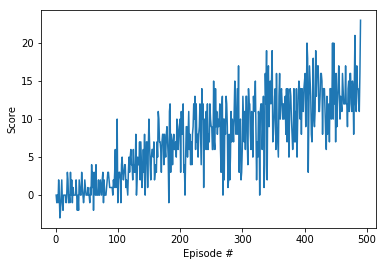

In [9]:
agent = YellowBananaThief(state_size, action_size, update_frequency=2)
try:
    _, stats = train(env, agent, target_score=13.0)
    plot(stats)
finally:
    env.close()